In [1]:
import graph_tool.all as gt
import numpy as np
from binance.client import Client
import pandas as pd
import ta as ta
from sklearn import preprocessing

In [2]:
#instantiating binance's API client object and requesting some data

client = Client("api key", "api secret")
fromdate = "10 Aug, 2019"
todate = "28 Dez, 2019"
symbol = "BTCUSDT"
kline_interval = "8h"

klines = client.get_historical_klines("BTCUSDT", kline_interval, fromdate)

period1 = 20


def format_klines(klines):
    OHLCV = []
    for k in klines:
        ohlcv = [float(k[1]), float(k[2]), float(k[3]), float(k[4]), float(k[5])]
        OHLCV.append(ohlcv)

    return OHLCV

OHLCV = format_klines(klines)
O = pd.Series([k[0] for k in OHLCV], name = "OPEN")
H = pd.Series([k[1] for k in OHLCV], name = "HIGH")
L = pd.Series([k[2] for k in OHLCV], name = "LOW")
C = pd.Series([k[3] for k in OHLCV], name = "CLOSE")
V = pd.Series([k[4] for k in OHLCV], name = "VOLUME")
R = pd.Series(C.values - O.values, name = "RETURNS")
X = [i for i in range(len(O))]

data_size = len(X)

In [7]:
#calculating some technical indicators to use as higher level properties

cr = ta.momentum.williams_r(H, L, C).fillna(method='backfill')
mfi = ta.volume.money_flow_index(H, L, C, V).fillna(method='backfill')
eom = ta.volume.ease_of_movement(H, L, C, V).fillna(method='backfill')
rsi = ta.momentum.rsi(C).fillna(method='backfill')
macd = ta.trend.macd_diff(C).fillna(method='backfill')

volatility = L.values / H.values
price_var = np.array([(close - open)/max([close,open]) for (close, open) in zip(C.values, O.values)])

In [8]:
#instantiating the graph object and adding vertices

g=gt.Graph(directed=False)
g.add_vertex(data_size)

<generator object Graph.add_vertex.<locals>.<genexpr> at 0x7f037c2e27b0>

In [9]:
#adding the acquired data to the vertices as properties

g.vp.closes = g.new_vp("float")
g.vp.closes.a = C.values
g.vp.volumes = g.new_vp("float")
g.vp.volumes.a = V.values
g.vp.volatility = g.new_vp("float")
g.vp.volatility.a = volatility
g.vp.price_var = g.new_vp("float")
g.vp.price_var.a = price_var
g.vp.rsi = g.new_vp("float")
g.vp.rsi.a = rsi.values
g.vp.pos_ = g.new_vp("vector<float>")

In [10]:
#scaling the data that will be used to make the geometric graph

x = np.array([volatility, price_var, rsi.values]).T
tx = preprocessing.quantile_transform(x, n_quantiles=100);


In [11]:
#global parameters for the construction of the graph sequence with increasing spatial resolutions

N=data_size

global init_foot, ibin


a=1
b=0 


init_foot = 0.006 #initial threshold distance step
ibin =      0.08 #initial threshold distance
fbin =      0.70 #final threshold distance

foot = (init_foot)*(10**a) #not being used, but we might want to vary the threshold distance step too
BIN = ibin - foot*b


In [12]:
gg, gpos = gt.geometric_graph(tx, ibin)
gg.vp.pos = gpos

In [13]:
gu = gt.graph_union(gg, g, intersection=g.vertex_index, internal_props=True)

In [14]:
gu.vp.pos_ = gt.sfdp_layout(gu, vweight = gu.vp.volumes, K=0.5)

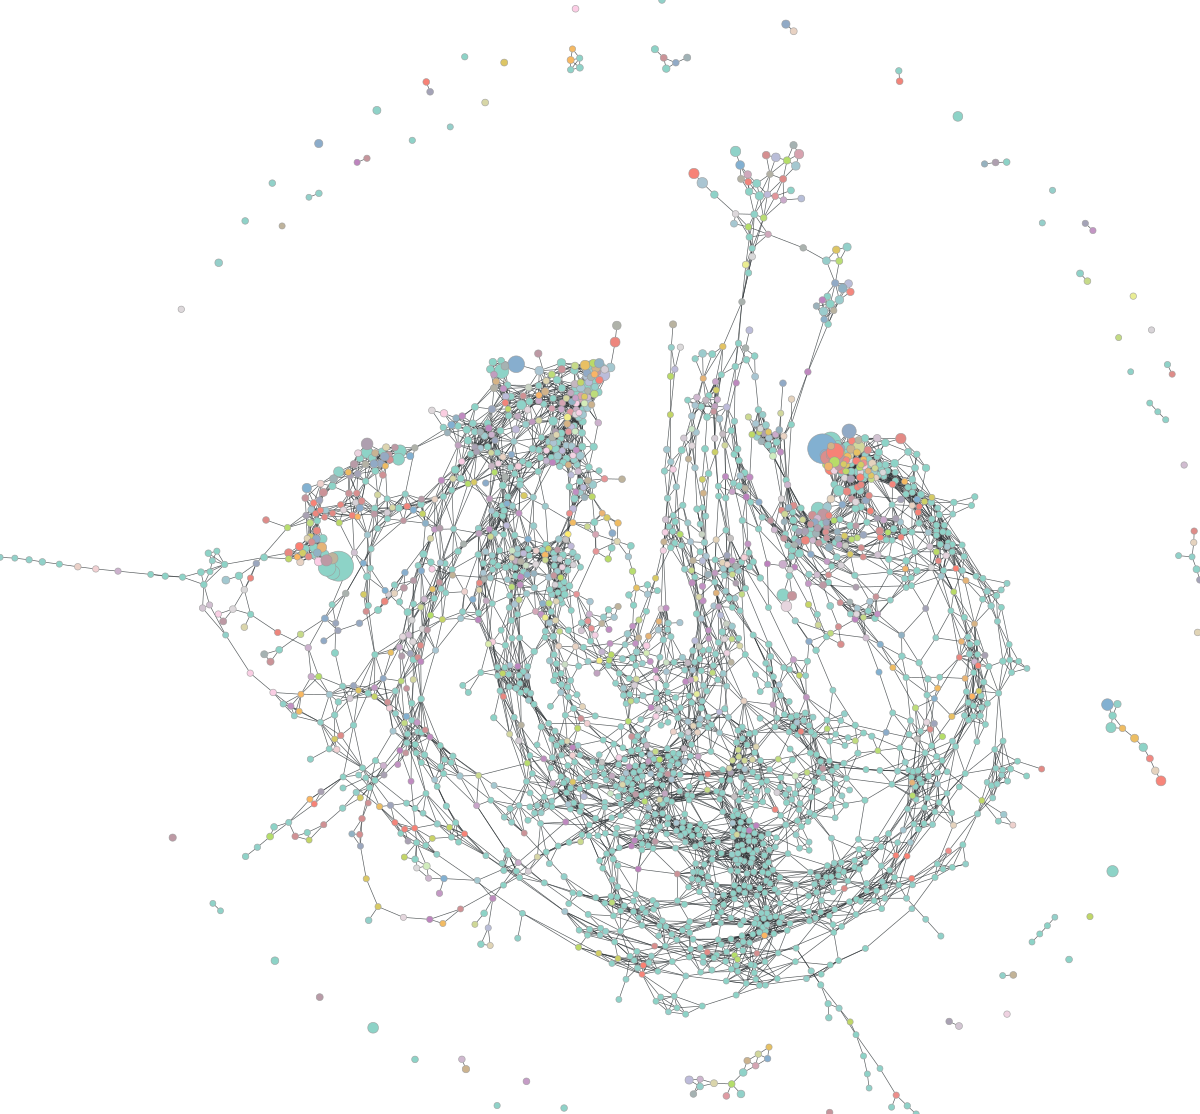

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f037dac7640, at 0x7f037dac9a60>

In [15]:
gt.graph_draw(gu, pos=gu.vp.pos_,fit_view=1.00, vertex_fill_color=gt.prop_to_size(gu.vp.closes, mi=1, ma=1.5, log=False, power=2),vertex_size=gt.prop_to_size(gu.vp.volumes, mi=3, ma=15, log=False, power=2))

In [16]:
def make_graphs(g, points, a, b, step):
    bin = a
    graphs = [g]
    while bin <= b:
        gg, gpos = gt.geometric_graph(points, bin)
        gu=graphs[-1].copy()
        ggedgelist=gg.get_edges()
        guedgelist=gu.get_edges()
        
        for edge in ggedgelist:

            if not(edge in guedgelist):
                gu.add_edge(edge[0], edge[1]) 

        gu.vp.pos_ = gt.sfdp_layout(gu, vweight = gu.vp.volumes, pos=gu.vp.pos_, max_iter=2, init_step=0.15, K=0.5)
        graphs.append(gu)

        bin+=step
    return graphs


In [17]:
graphlist = make_graphs(gu, tx, ibin,fbin, init_foot)

In [38]:
for i, gu in enumerate(graphlist):
    gt.graph_draw(gu, pos=gu.vp.pos_, vertex_fill_color=gt.prop_to_size(gu.vp.closes, mi=1, ma=1.5, log=False, power=2), edge_pen_width=0.5, vertex_size=gt.prop_to_size(gu.vp.volumes, mi=3, ma=15, log=False, power=3), output="draw %i.png" %i)